In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter,
import matplotlib.ticker as ticker
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from numpy import ndenumerate

import seaborn as sns
import autograd.numpy as np
from autograd import grad, elementwise_grad
import pandas as pd
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
plt.rcParams['font.size'] = 14


In [35]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 

# Creating the design matrix, from lecture notes
def create_X(x, y):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = 2 # Number of elements in beta
    X = np.ones((N,l))
    X[:,0] = x
    X[:,1] = y
    return X


# Defining the Mean square error, from lecture notes
def CostFunction(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)

def CostFunctionClassification(ao,target):
    n= len(ao)
    return -1/n*np.sum(target*np.log(ao) + (1-target)*np.log(1-ao))
    

def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)

# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def DerivariveCostFunc(y,ytilde):
    n = len(y)
    return 2/n*(y-ytilde)

def Sigmoid(y):
    return np.exp(y)/(1+np.exp(y))

def RELU(y):
    return np.maximum(0,y)

def lexyRelu(y):
    return np.maximum(0.01*y,y)

def Identity(y):
    return y

### note n_hidden is assumed to be a list in this case
def Set_weights_and_bias(n_in, n_hidden,n_out):
    W = []
    b = []
    W_grad =[]
    b_grad = []
    #### Setting hiden weights
    W.append(0.1*np.random.randn(n_in, n_hidden[0]))
    b.append( np.zeros(n_hidden[0]) +0.1)
    W_grad.append(np.random.randn(n_in, n_hidden[0]))
    b_grad.append( np.zeros(n_hidden[0]) +0.00001)
    for i in range(1,len(n_hidden)):
            W.append(0.1*np.random.randn(n_hidden[i-1], n_hidden[i]))
            b.append( np.zeros(n_hidden[i]) +0.1)
            W_grad.append(np.random.randn(n_hidden[i-1], n_hidden[i]))
            b_grad.append( np.zeros(n_hidden[i]) +0.01)

#### setting output weights
    W.append(0.1*np.random.randn(n_hidden[-1], n_out))
    b.append(np.zeros(n_out) +0.1)
    W_grad.append(np.random.randn(n_hidden[-1], n_out))
    b_grad.append( np.zeros(n_out) +0.01)
    return W, b, W_grad, b_grad    
###### The gradients are only sett so that they wil have the right dimensions

#### From lecture notes
def feed_forward_train(X,W, b,activation_function, output_function):
    Z_h = []
    A_h = [] 
#### Hidden attac
    Z_h.append( X@W[0] + b[0])
    A_h.append(activation_function(Z_h[0]))
    for i in range(1,len(W)-1):
        Z_h.append( A_h[-1]@W[i] + b[i])
        A_h.append(activation_function(Z_h[-1]))
    Z_h.append( A_h[-1]@W[-1] + b[-1])
    A_h.append(output_function(Z_h[-1]))
    return Z_h, A_h

def back_prop(X,Target,W, W_grad, b, b_grad,activation_function, output_function,hyper_par,costfunk):
    cost_deriv = elementwise_grad(costfunk, 0)
    
    Z_h,A_h = feed_forward_train(X,W, b,activation_function, output_function)
    #error_out = DerivariveCostFunc(A_h[-1],Target)*elementwise_grad(output_function,0)(Z_h[-1]) #* derivative of output_function
    error_out = cost_deriv(A_h[-1],Target)*elementwise_grad(output_function,0)(Z_h[-1]) #* derivative of output_function
    W_grad[-1] = (A_h[-2]).T @ error_out + 2*hyper_par*W[-1]
    b[-1] = np.sum(error_out, axis=0)
    for i in range(len(W)-1,1,-1):
      #  print(i)
        error_hiden = (error_out @ W[i].T)* elementwise_grad(activation_function,0)(Z_h[i-1])
        W_grad[i-1] = (A_h[i-2]).T @ error_hiden + 2*hyper_par*W[i-1]
        b_grad[i-1] = np.sum(error_hiden, axis=0)
        error_out = np.copy(error_hiden)
    ### hidden error
    error_hiden = (error_out @ W[1].T)* elementwise_grad(activation_function,0)(Z_h[0]) #*  a_h * (1 - a_h) # the last two terms are the derivative of the sigmoid
    W_grad[0] = X.T @error_hiden+ 2*hyper_par*W[0]
    b_grad[0] = np.sum(error_hiden,axis=0)
    return W_grad, b_grad



Activationfunction:  1
[0.47552448]
[0.9020979]
[0.90909091]
[0.93706294]
[0.93006993]
[0.95104895]
[0.95104895]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.38461538]
[0.56643357]
[0.91608392]
[0.91608392]
[0.93706294]
[0.94405594]
[0.95104895]
[0.95104895]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95104895]
[0.95804196]
[0.95104895]
[0.95804196]
[0.95804196]
[0.95804196]
[0.38461538]
[0.38461538]
[0.39160839]
[0.41958042]
[0.86713287]
[0.93006993]
[0.95104895]
[0.95104895]
[0.95104895]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.95804196]
[0.96503497]
[0.96503497]
[0.96503497]
[0.97202797]
[0.97202797]
[0.97202797]
[0.97202797]
[0.97202797]
[0.97202797]


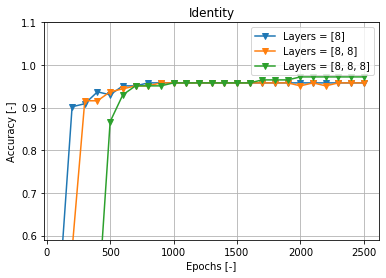

In [48]:
#Setting the number of minibatches to be static
Minibach = 8


# Learningrate
eta =.01
hyper = 0

funklist = [Identity]
funkliststr = [ "Identity"]


# Loading the breast cancer data and processing it
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target.reshape(-1,1),random_state=1)
scaler =StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Defining the number of epochs you want to run over
epochlist = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500]
epochs = 2500
# Defining the layers we want to run the epochs over
layerlist = [[8],[8,8],[8,8,8]]

#matrix to hold the accuracy for the different configs
A = np.zeros( ( len(epochlist), len(layerlist) ) )

index = 0
# 
for a,actifunk in np.ndenumerate(funklist):
    A = np.zeros( ( len(epochlist), len(layerlist) ) )
    # This loop calculates the accuracy for a set of different layers over different number of epochs
    print("Activationfunction: ", 1)
    for l,layers in np.ndenumerate(layerlist):
        W,b,W_grad,b_grad=Set_weights_and_bias(30,layers,1)
        e = 0
        # Running over all the epochs
        for i in range(epochs):
            miniBach = np.random.randint(Minibach)
            MiniBachSize = int(X_train.shape[0]/Minibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)

            W_grad,b_grad=back_prop(X_train[miniBachMin:miniBachMax],y_train[miniBachMin:miniBachMax],W, W_grad, b, b_grad,actifunk, Sigmoid,hyper,CostFunctionClassification)

            # updating the weights
            for j in range(len(W)):
                W[j] -= eta*W_grad[j]
                b[j] -= eta*b_grad[j]
            if i% 100 == 0:
                Z_h, A_h = feed_forward_train(X_test,W, b, actifunk, Sigmoid)

                # Setting the last layer
                pred = A_h[-1]

                # Making it into binary probability
                for n, elem in ndenumerate(pred):
                                    if elem<0.5:
                                        pred[n] = 0
                                    elif elem >=0.5:
                                        pred[n] = 1

                # Adding the accuracy matrix to its position
                A[e,l] = accuracy_score(pred,y_test)
                print(A[e,l])
                e += 1
    
    for i in range(A.shape[1]):
        plt.plot(epochlist, A[:,i],"-v",label = f"Layers = {layerlist[i]}")


    plt.legend()
    plt.grid()
    plt.title(f"{funkliststr[index]}")
    plt.ylabel("Accuracy [-]")
    plt.xlabel("Epochs [-]")
    plt.ylim(0.59,1.1)
    plt.savefig(f"accuracy_different_layers_actifunk_{funkliststr[index]}.pdf")
    plt.show()
    index += 1

In [49]:

#print(A)
print(np.max(A))
print(np.argmax(A))
maxarg = np.unravel_index(A.argmax(), A.shape)
print(maxarg)
print(A[maxarg])

0.972027972027972
59
(19, 2)
0.972027972027972
